# Lecture 11.1: Statistical Modeling
<div style="border: 1px double black; padding: 10px; margin: 10px">
From now until the end of the course we will focus on statistical modeling ([Part IV] of your book).

</div>    




In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## What is a model
A statistical model is a mathematical formula that relates an outcome with one or more explanatory variables.

$$\underbrace{Y}_{\text{outcome}} = \underbrace{f}_{\text{model function}}(\underbrace{X}_{\text{explainer}}) + 
    \underbrace{\epsilon}_\text{noise}$$

### Model classes
The types of functions $f$ that we allow determine what is called the *model class*. For example, in STATS 250 you learned about linear regression, where $f$ is any function of the form 

$$f(x) = a + bx $$

for some *parameters* $a$ and $b$. This defines a whole *family* of models: one for each choice of slope and intercept.

### Model fitting
The process of *fitting* a model refers to selecting the particular choice $\hat{a},\hat{b}$ from the family of models that we have chosen, in order to best fit the data. The fitted model is the member of the model family we have selected that is "closest" to the data. This *does not* mean that this is the "true" model! In most cases there is no "true" model. The goal of a model is not to uncover truth, but to discover a simple approximation that is still useful.

### Model selection
There is also the question of which family of models to use. In other words, which types of functions $f(x)$ to use. To use a fashionable example, we could have instead chosen our model family to be 

$$\{f: \text{$f$ is a neural network}\}.$$ 

The problem of choosing a model family is known as *model selection*. It is a much trickier problem than model fitting because there is no one correct answer: "all models are wrong"; the appropriate model family balances our needs for interpretability, predictiveness, etc.

### Example
We'll use the `modelr` package (again part of tidyverse) to learn about modeling.

In [2]:
library(modelr)

The `modelr` package comes with a simple bivariate dataset that we can model:

In [3]:
sim1 %>% print

# A tibble: 30 × 2
       x     y
   <int> <dbl>
 1     1  4.20
 2     1  7.51
 3     1  2.13
 4     2  8.99
 5     2 10.2 
 6     2 11.3 
 7     3  7.36
 8     3 10.5 
 9     3 10.5 
10     4 12.4 
# … with 20 more rows


The first step is to explore the data using the techniques we have already learned:

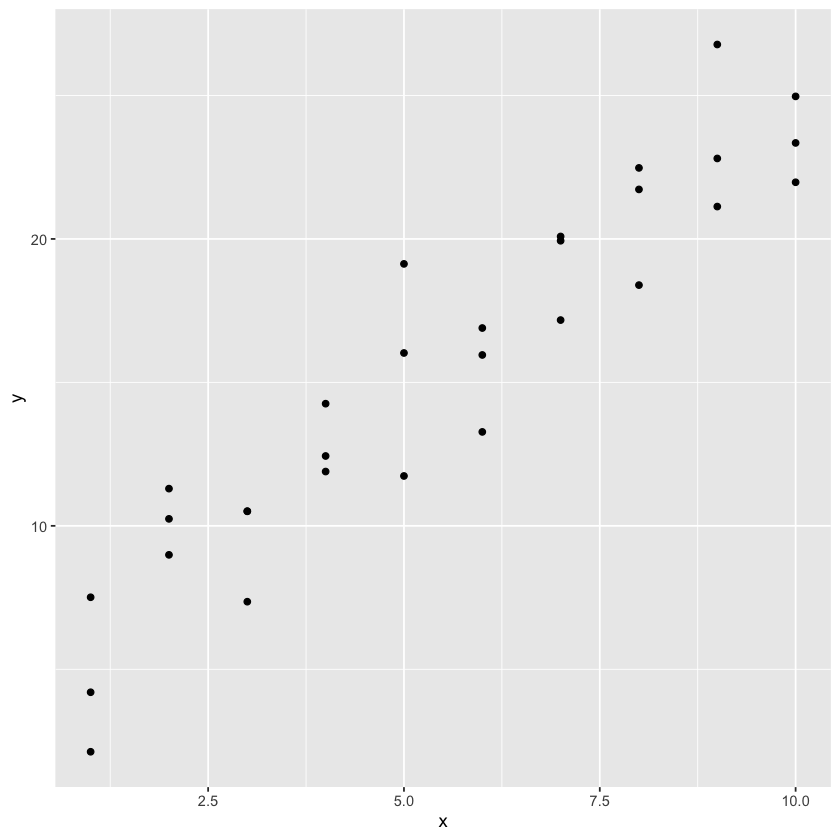

In [9]:
ggplot(sim1, aes(x, y)) + geom_point()

There is a strong linear relationship. We suspect that a good model might be the one we saw above: $y = a + bx$. If we select a particular $a$ and $b$, this gives us a potential model for the data. We can plot this for various choices of $a$ and $b$ and see visually see how well it might fit:

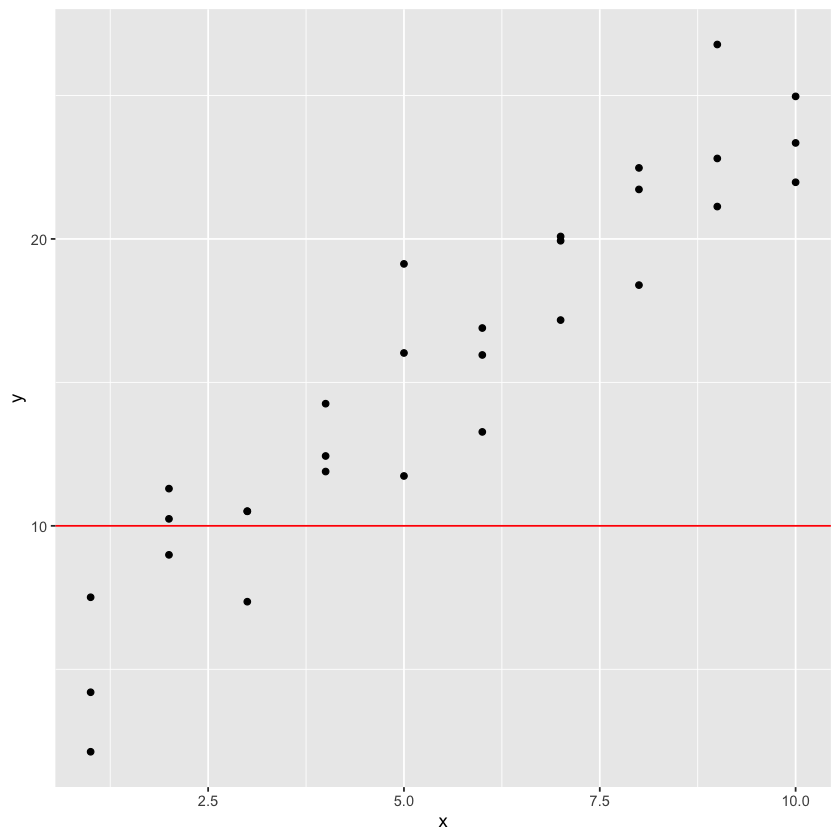

In [10]:
a = 10
b = 0
ggplot(sim1, aes(x, y)) + 
  geom_abline(aes(intercept = a, slope = b), color="red") +
  geom_point()

The red line represents the value of $y$ that we would predict for each value of $x$. To measure how good our model fit is we can do the following: for each pair of data points $(x_i,y_i)$, measure the distance $|\hat{y}_i - y_i|$ between predicted and observed values of $y_i$. The value $\hat{y}_i - y_i$ is called the *residual*. It's the component of the data that isn't predicted by our model. Adding up the residuals gives us a measure of how good our model fits the data. If we predict the data perfectly ($\hat{y}_i = y_i$ for all $i$) then this would equal zero, so lower values are better. (Later you will learn that this is only true up to a point; it is generally not a good idea to fit the data perfectly.)

Let's define a model from this class:

In [11]:
model1 = function(a,b,x) {
    a + b * x 
}

Now we will write a function which takes a model and plots the residuals for each data point:

In [12]:
a <- 10
b <- 0
sim1_jitter  <- sim1 %>% mutate(x = x +rnorm(length(x),sd=0.3))

plot_diff <- function(a,b){
    sim1_jitter %>% mutate(y_hat = model1(a,b,x)) %>% 
    ggplot+ geom_point(aes(x=x,y=y))  + 
    geom_point(aes(x,y_hat),shape=2) +
    geom_abline(aes(intercept = a, slope=b),color="red")+
    geom_segment(aes(x=x, xend=x,y=y,yend=y_hat),color="blue")
    }

(I have jittered the data slightly to make the regression effect more apparent.)

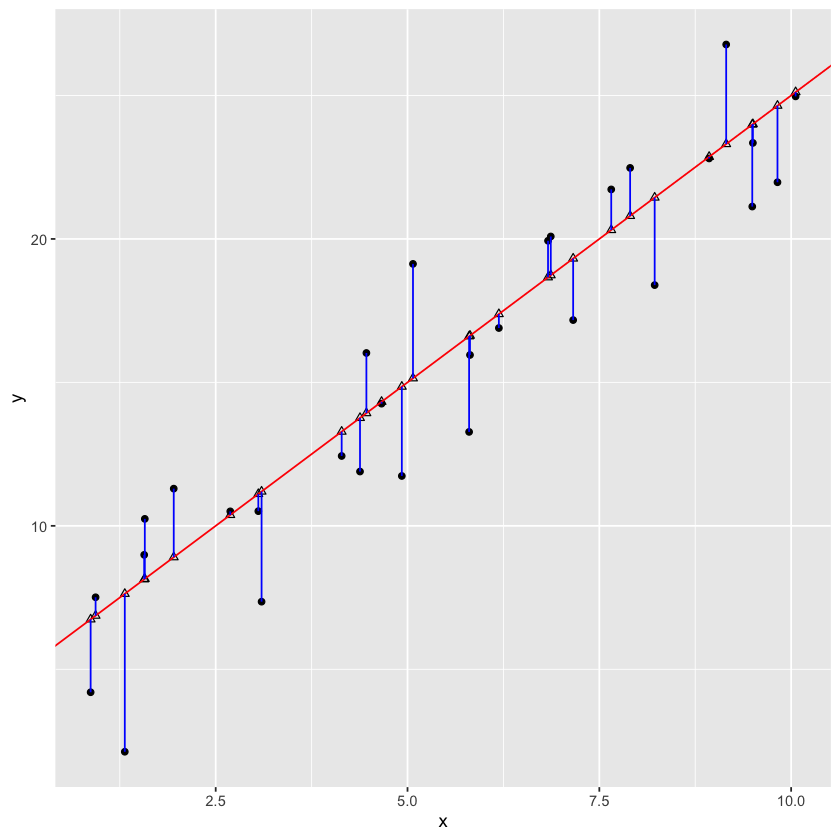

In [13]:
plot_diff(a=5, b=2)

To measure how well our model peforms we define a function which adds up the square of the residuals:

In [14]:
# residuals = y_hat - y 
measure_distance <- function(a,b,data){
    
    diff <- data$y - model1(a,b,data$x)
    sqrt(mean(diff^2))
    
}
measure_distance(a=5,b=2,sim1)

[1] 2.190166

Now we want to figure out what is the best fitting model, i.e. the choice of $a$ that minimizes `measure_distance` as defined above. Let's first try simply generating a bunch of random models and seeing which one has the smallest `measure_distance`:

In [15]:
sim1_dist <- function(a,b){
    measure_distance(a,b,sim1)
}
a <- runif(250,min=-20,max=40)
b <- runif(250,min=-5,max=5)
dist <- map2_dbl(a,b,sim1_dist)
dist %>% print

  [1] 24.255526  8.113234 46.748159 33.422343  6.532924 47.279730 15.844149
  [8]  9.395477 15.777195 46.002429 31.274188 16.298181 42.897061 26.514930
 [15] 28.538775 14.922823 45.601519 12.594539 17.994021 11.426751  4.615995
 [22] 11.511170 22.221546  8.645898 12.934840 11.231316  8.506806 14.990380
 [29] 35.765791 18.188778 45.963921 20.380370 20.702093 31.861587 24.296097
 [36] 31.455717 21.003698 46.265972 37.058427  4.592978  9.577119 13.760073
 [43] 13.759541 24.029894 13.128181 14.626177  4.283761 33.082937  5.712271
 [50]  2.509089  6.953941 16.726482 20.422323 12.251862 20.292714  8.229778
 [57] 41.807080 13.283247 31.033598 10.087709  3.704316 29.139434 30.705844
 [64] 32.691812 32.699592 19.759772 14.850546 15.423930  7.328177 17.341434
 [71] 14.920645 11.032357 20.567642  9.736863 53.129087 23.761132 20.267361
 [78] 43.851272 16.253835 32.350816 28.052299 44.093305 47.111688 18.680159
 [85] 27.072275 27.972056 18.066543 24.042930 20.122640 20.752902 18.607785
 [92] 47.115

Let's look at the three best-fitting models (the three indices $i$ for which `sim1_dist(a, b)` is smallest).

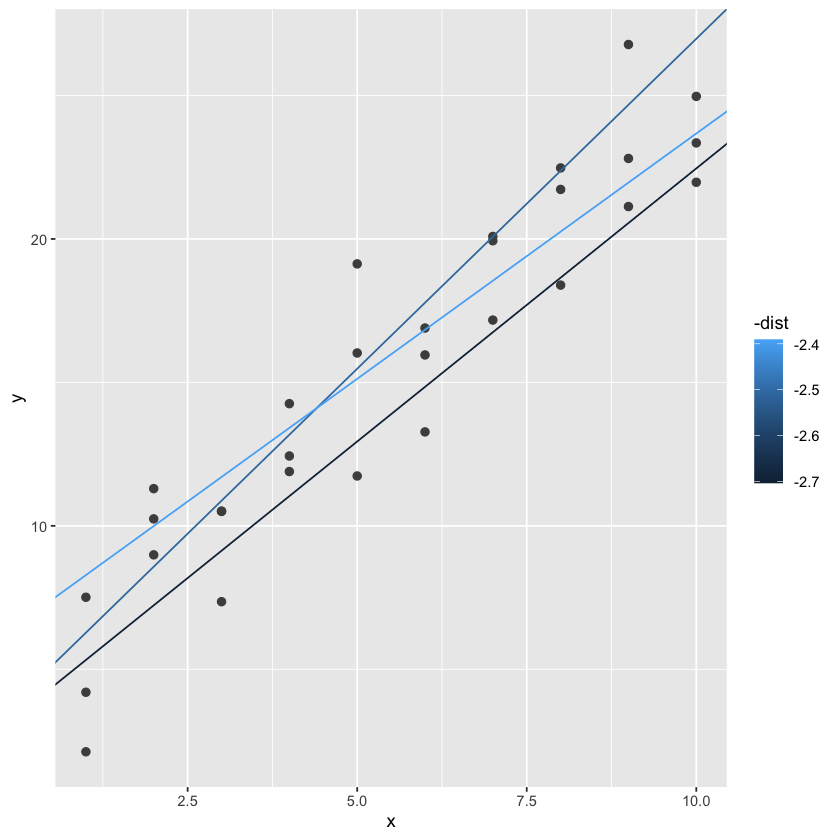

In [16]:
models = tibble(a=a, b = b, dist = dist)
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(
    aes(intercept = a, slope = b, colour = -dist), 
    data = filter(models, rank(dist) <= 3)
) #+ geom_smooth(method="lm", se = F)

We can also visualize the model fits by plotting `dist[i]` for each pair `c(a[i], b[i])`:

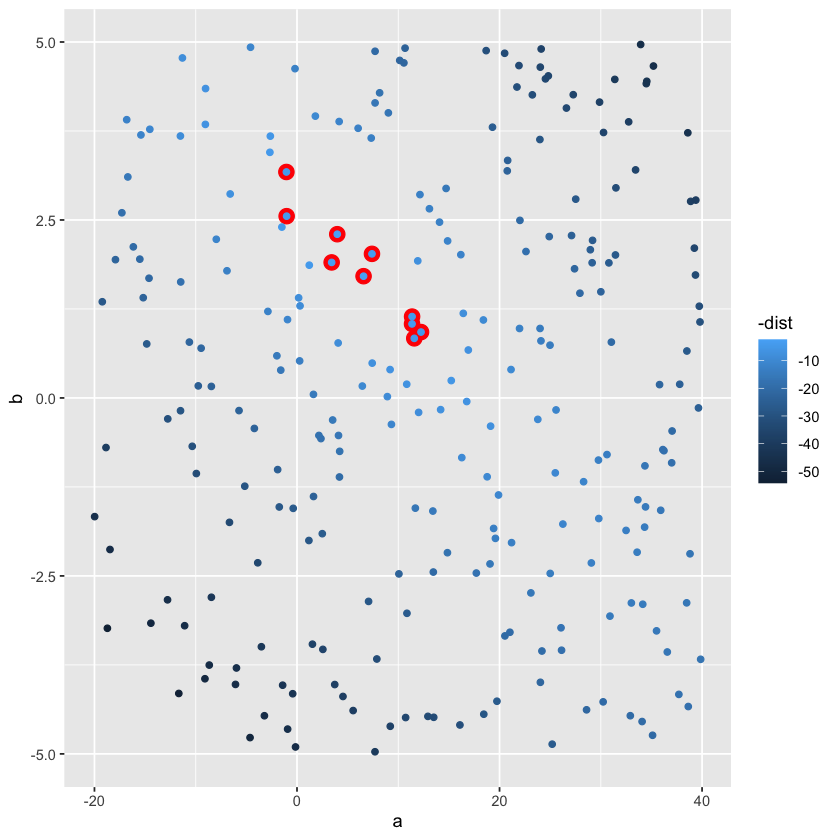

In [17]:
ggplot(models, aes(a, b)) +
  geom_point(data = filter(models, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist))

Rather than exploring the models randomly let us systematically try all points on a grid of values:

In [18]:
# seq(1, 3, length = 25) %>% print
grid <- expand.grid(
  a = seq(-5, 20, length = 100),
  b = seq(1, 3, length = 100)    
) %>% mutate(dist = purrr::map2_dbl(a, b, sim1_dist)) %>% print

                a        b      dist
1     -5.00000000 1.000000 15.452475
2     -4.74747475 1.000000 15.207395
3     -4.49494949 1.000000 14.962562
4     -4.24242424 1.000000 14.717989
5     -3.98989899 1.000000 14.473689
6     -3.73737374 1.000000 14.229676
7     -3.48484848 1.000000 13.985966
8     -3.23232323 1.000000 13.742574
9     -2.97979798 1.000000 13.499517
10    -2.72727273 1.000000 13.256814
11    -2.47474747 1.000000 13.014485
12    -2.22222222 1.000000 12.772552
13    -1.96969697 1.000000 12.531036
14    -1.71717172 1.000000 12.289962
15    -1.46464646 1.000000 12.049358
16    -1.21212121 1.000000 11.809252
17    -0.95959596 1.000000 11.569674
18    -0.70707071 1.000000 11.330659
19    -0.45454545 1.000000 11.092242
20    -0.20202020 1.000000 10.854464
21     0.05050505 1.000000 10.617367
22     0.30303030 1.000000 10.380997
23     0.55555556 1.000000 10.145406
24     0.80808081 1.000000  9.910649
25     1.06060606 1.000000  9.676786
26     1.31313131 1.000000  9.443885
2

If we repeat the same plot, we see that the best fitting models are roughly centered around `a=4,b=2`.

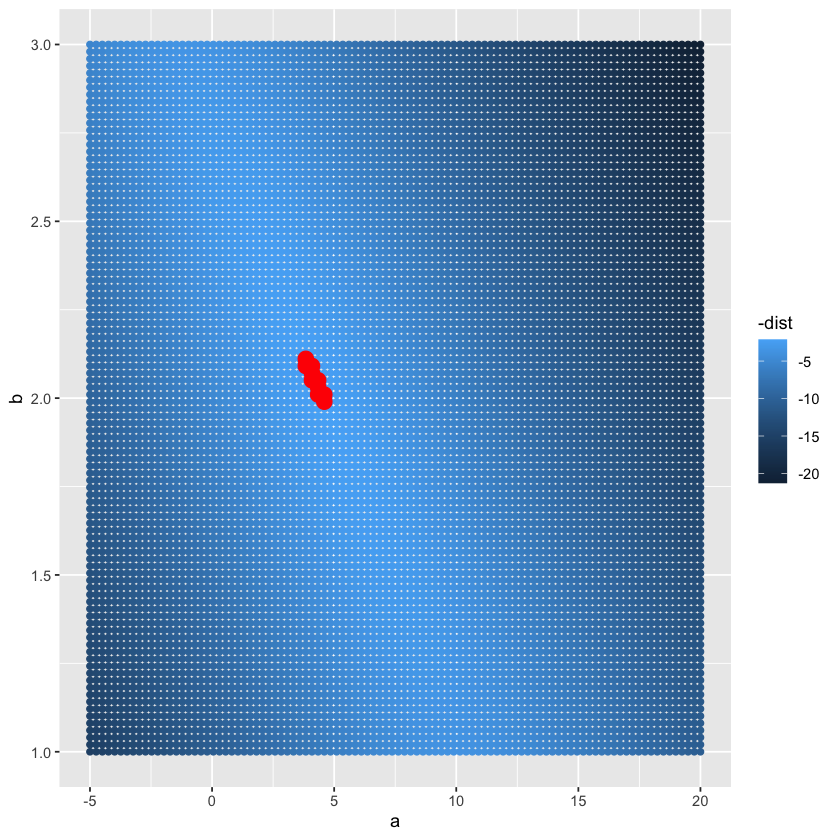

In [19]:
ggplot(grid, aes(a, b)) +
  geom_point(aes(colour = -dist))+
  geom_point(data = filter(grid, rank(dist) <= 10), size = 4, colour = "red") 

If we plot these models they all fit the data pretty well:

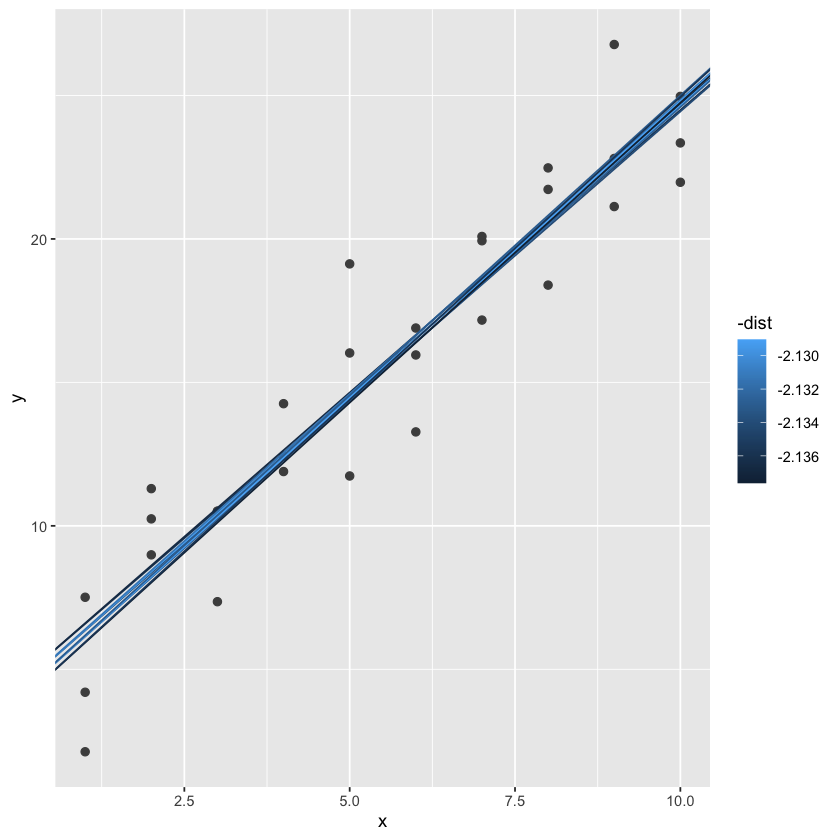

In [20]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(
    aes(intercept = a, slope = b, colour = -dist), 
    data = filter(grid, rank(dist) <= 10)
  )

To find the "best" model you could imagine taking a finer and finer grid of points:

In [22]:
grid <- expand.grid(
  a = seq(-5, 20, length = 50),
  b = seq(1, 3, length = 50)
  ) %>% 
  mutate(dist = purrr::map2_dbl(a, b, sim1_dist))

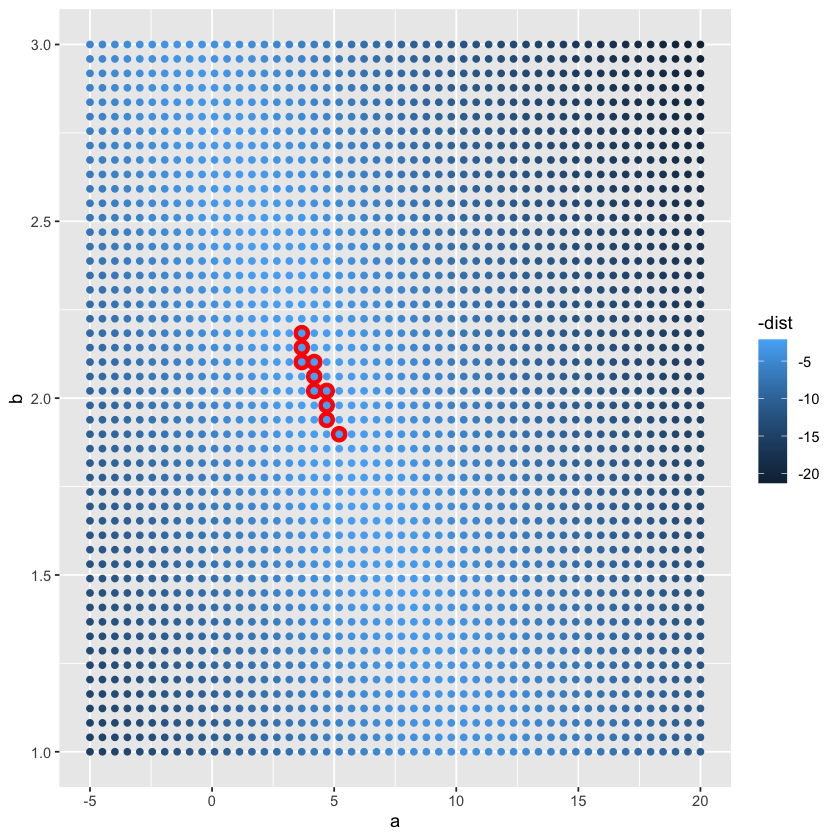

In [23]:
ggplot(grid, aes(a, b)) +
  geom_point(data = filter(grid, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist))

But this "brute force" approach is wasteful. We can do much better by using an optimization algorithm to find the minimum for us.

### Optimization in R
Optimization means "find the minimum of a function". In R the command `optim` can be used to optimize a function:

We can use `optim` to find the values `a1` and `a2` that minimize `sim1_dist`: 

In [24]:
res = optim(par = c(0, 0), 
            fn = function(a) sim1_dist(a[1], a[2])) %>% print
 a_opt = res$par

$par
[1] 4.222248 2.051204

$value
[1] 2.128181

$counts
function gradient 
      77       NA 

$convergence
[1] 0

$message
NULL



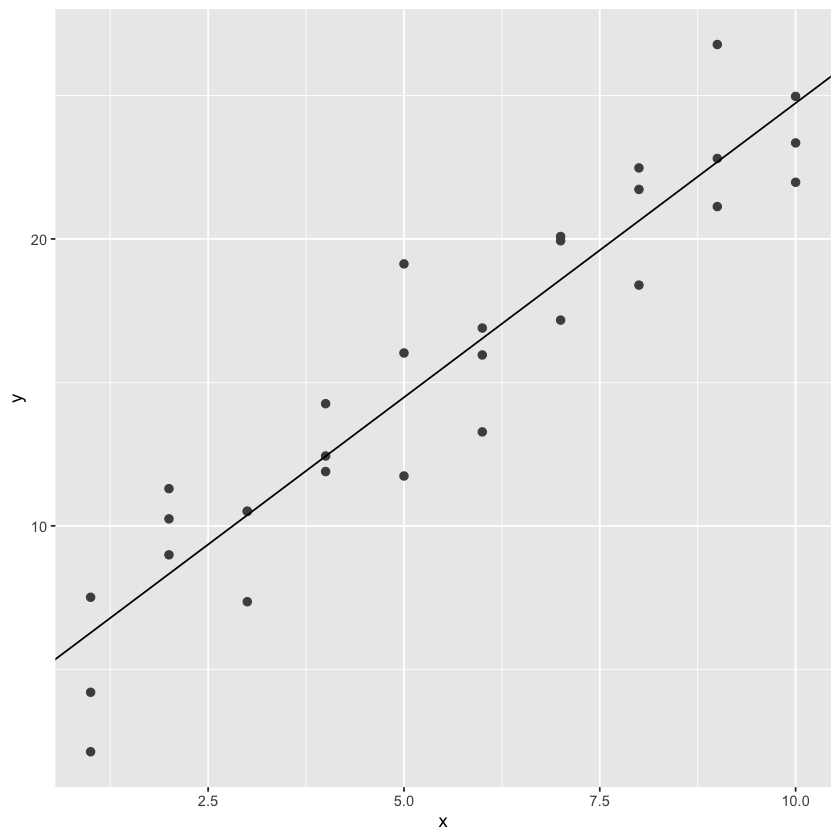

In [25]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(aes(intercept = a_opt[1], slope = a_opt[2]))

### The `lm` command
The simple linear model class we are considering is a special case of the larger family

$$y = a_0 + a_1 x_1 + \dots + a_p x_p.$$

R has a special commmand `lm` used to fit this type of model:

In [26]:
sim1_mod = lm(y ~ x, data = sim1)
sim1_mod


Call:
lm(formula = y ~ x, data = sim1)

Coefficients:
(Intercept)            x  
      4.221        2.052  


Note that these are the same parameter estimates that we got using `optim`:

In [28]:
a_opt

[1] 4.222248 2.051204

## Visualizing models
In this section we will learn some ways to visualize statistical models. One way is to look at the *predictions* made by the model over the observed range of values for our explanatory variable(s). The command `modelr::data_grid` will generate this for us:

In [29]:
sim1 %>% print 

# A tibble: 30 × 2
       x     y
   <int> <dbl>
 1     1  4.20
 2     1  7.51
 3     1  2.13
 4     2  8.99
 5     2 10.2 
 6     2 11.3 
 7     3  7.36
 8     3 10.5 
 9     3 10.5 
10     4 12.4 
# … with 20 more rows


Next we will add the predictions for each $x$ value in `grid`:v

In [30]:
grid <- sim1 %>% add_predictions(sim1_mod) %>%add_residuals(sim1_mod)%>% print

# A tibble: 30 × 4
       x     y  pred    resid
   <int> <dbl> <dbl>    <dbl>
 1     1  4.20  6.27 -2.07   
 2     1  7.51  6.27  1.24   
 3     1  2.13  6.27 -4.15   
 4     2  8.99  8.32  0.665  
 5     2 10.2   8.32  1.92   
 6     2 11.3   8.32  2.97   
 7     3  7.36 10.4  -3.02   
 8     3 10.5  10.4   0.130  
 9     3 10.5  10.4   0.136  
10     4 12.4  12.4   0.00763
# … with 20 more rows


Finally, we plot these predictions using `ggplot`:

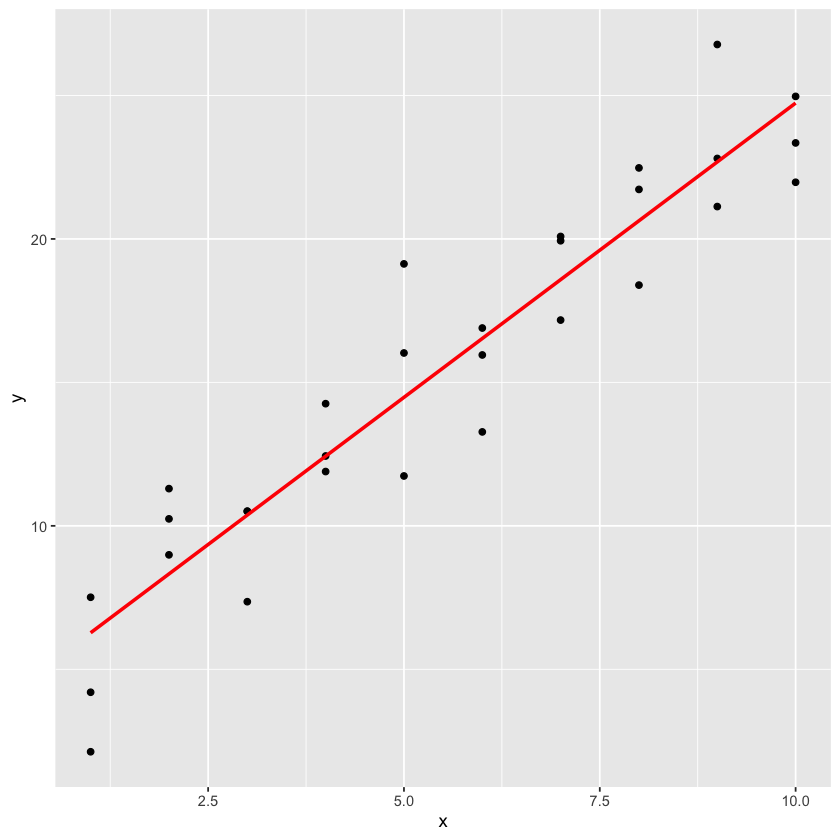

In [31]:
ggplot(sim1, aes(x)) +
  geom_point(aes(y = y)) +
  geom_line(aes(y = pred), data = grid, colour = "red", size = 1)

What is the advantage of using `modelr` here versus just extracting the coefficients and doing it ourselves, as before? The `modelr` code works with any model. We could have used something more complicated for `sim1_mod`:

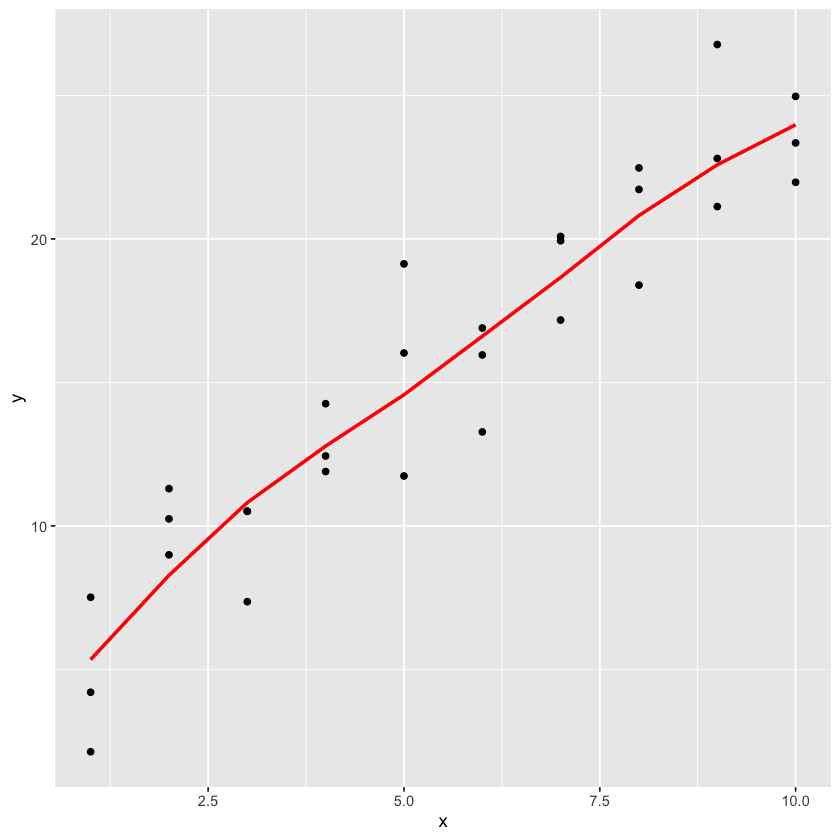

In [32]:
grid = grid %>% add_predictions(loess(y ~ x, sim1))
ggplot(sim1, aes(x)) +
  geom_point(aes(y = y)) +
  geom_line(aes(y = pred), data = grid, colour = "red", size = 1)

### Residuals
Each data point $y_i$ can be decomposed as 

$$y_i = \underbrace{\hat{y}_i}_\text{prediction} + \underbrace{\epsilon_i}_\text{residual}.$$

The prediction is the pattern in the data that the model has captured, and the residual is what is left over. To explore the residuals, use `add_residuals()`.

In [34]:
(sim1 = sim1 %>% add_residuals(sim1_mod)) %>% print

# A tibble: 30 × 3
       x     y    resid
   <int> <dbl>    <dbl>
 1     1  4.20 -2.07   
 2     1  7.51  1.24   
 3     1  2.13 -4.15   
 4     2  8.99  0.665  
 5     2 10.2   1.92   
 6     2 11.3   2.97   
 7     3  7.36 -3.02   
 8     3 10.5   0.130  
 9     3 10.5   0.136  
10     4 12.4   0.00763
# … with 20 more rows


If you recall from STATS 250, the linear model assumes that the residuals $\epsilon_i$ are independent and normally distributed (actually not needed). By visualizing the residuals, we may judge whether this assumption holds or not:

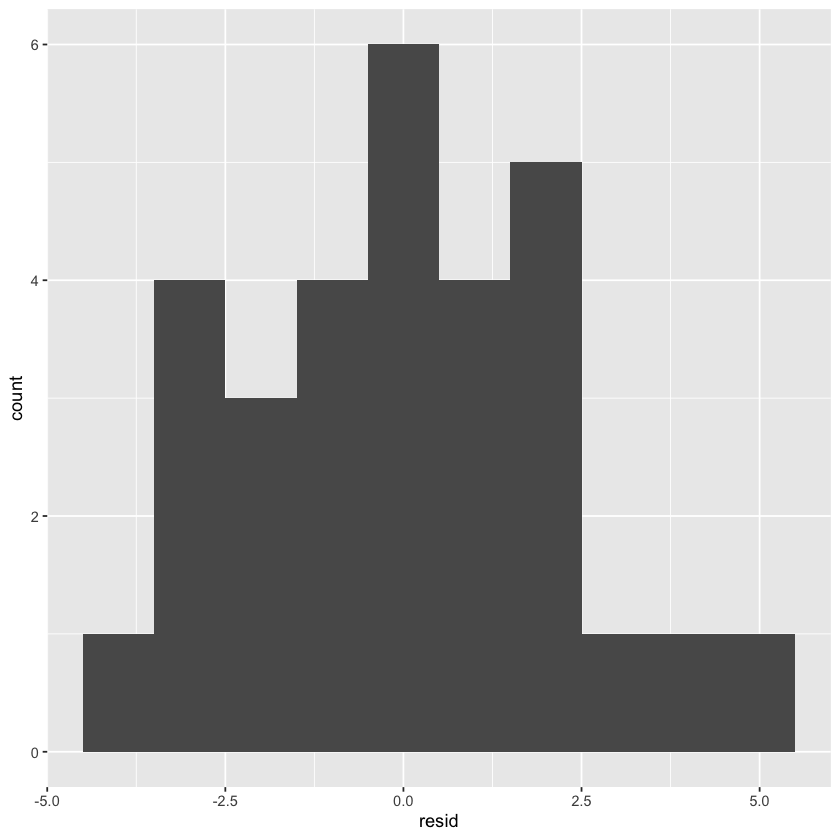

In [37]:
ggplot(sim1) + geom_histogram(aes(x=resid), binwidth=1)

If the model has done a good job of capturing patterns in the data, then the residuals should look like random noise. (In other words, if the residuals contain obvious patterns, then there is more modeling work to be done!) You should confirm this by visualizing the residuals:

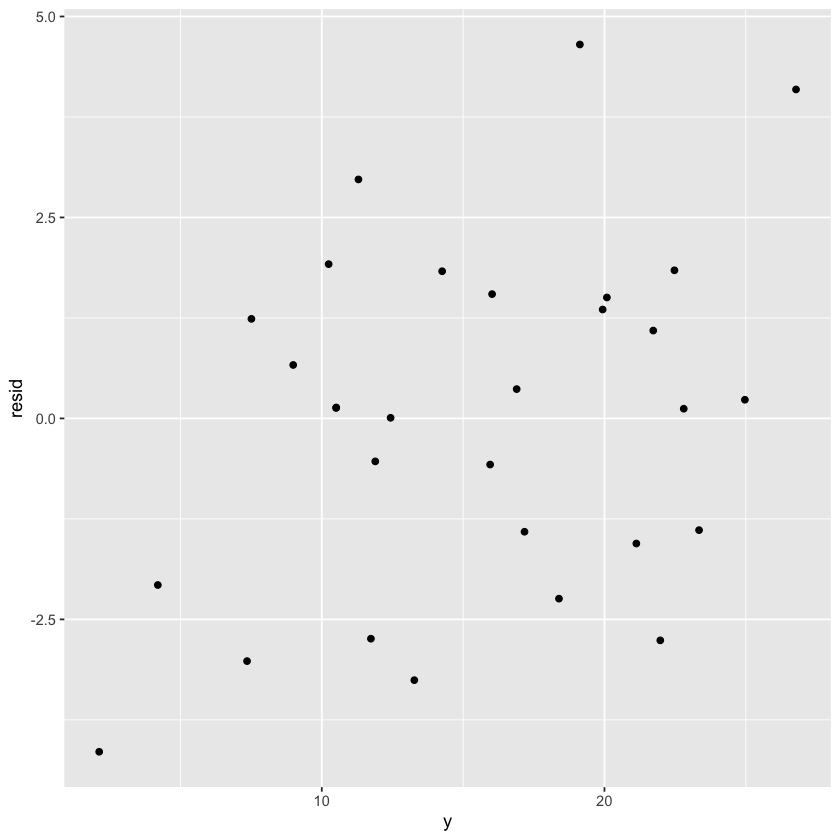

In [38]:
ggplot(sim1) + geom_point(aes(x=y, y=resid))

## Formulas
We have seen examples of formulas when working with the `facet_*()` commands, and also used them in place of anonymous functions with `map`. Formulas are most commonly used in model fitting commands like `lm`. 

We saw that the notation `y ~ x` cause R to fit the model 

$$y = a_1 + a_2 x.$$

The command `model_matrix` can show us exactly how formulas work on specific data examples:

In [39]:
 df <- tribble(
   ~y, ~x1, ~x2,
   4, 2, 5,
   5, 1, 6,
   1, 2, 3
 ) %>% print
mdl <-  lm(y ~ x1 + x2, df) %>% print
add_predictions(df, mdl)%>% print
model_matrix(df, y ~ x1 + x2) %>% print

# A tibble: 3 × 3
      y    x1    x2
  <dbl> <dbl> <dbl>
1     4     2     5
2     5     1     6
3     1     2     3

Call:
lm(formula = y ~ x1 + x2, data = df)

Coefficients:
(Intercept)           x1           x2  
       -4.5          0.5          1.5  

# A tibble: 3 × 4
      y    x1    x2  pred
  <dbl> <dbl> <dbl> <dbl>
1     4     2     5  4.00
2     5     1     6  5   
3     1     2     3  1   
# A tibble: 3 × 3
  `(Intercept)`    x1    x2
          <dbl> <dbl> <dbl>
1             1     2     5
2             1     1     6
3             1     2     3


By default, R will add an intercept term. If you want to fit a model with no intercept, you should subtract 1 from the formula:

In [40]:
model_matrix(df, y ~ x1 - 1) %>% print

# A tibble: 3 × 1
     x1
  <dbl>
1     2
2     1
3     2


In [41]:
model_matrix(df, y ~ x1 + x2) %>% print

# A tibble: 3 × 3
  `(Intercept)`    x1    x2
          <dbl> <dbl> <dbl>
1             1     2     5
2             1     1     6
3             1     2     3
